# **US ELECTIONS 2020**

Проект по предметот Вовед во науката на податоци

Датасет: https://www.kaggle.com/unanimad/us-election-2020?select=president_county_candidate.csv

Изработиле: Jana Mitrovska (181080), Teodora Spasovska (181090)

# **Reading the dataset**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Го избравме ова множество на податоци бидејќи претседателските избори се порелевантна тема, и имаше разновидни податоци (нумерички и категориски).

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/US_Elections2020/president_county_candidate.csv')

In [ ]:
data.head()

,state,county,candidate,party,total_votes,won
0,Delaware,Kent County,Joe Biden,DEM,44552,True
1,Delaware,Kent County,Donald Trump,REP,41009,False
2,Delaware,Kent County,Jo Jorgensen,LIB,1044,False
3,Delaware,Kent County,Howie Hawkins,GRN,420,False
4,Delaware,New Castle County,Joe Biden,DEM,195034,True


# **Visualizations**

Прво проверуваме во множеството на податоци дали имаме недостаток на податоци.

In [ ]:
print(data['state'].isnull().sum())
print(data['county'].isnull().sum())
print(data['candidate'].isnull().sum())
print(data['party'].isnull().sum())
print(data['total_votes'].isnull().sum())
print(data['won'].isnull().sum())

0
0
0
0
0
0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32177 entries, 0 to 32176
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   state        32177 non-null  object
 1   county       32177 non-null  object
 2   candidate    32177 non-null  object
 3   party        32177 non-null  object
 4   total_votes  32177 non-null  int64 
 5   won          32177 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.3+ MB


Правиме табела каде што ги групираме колоните candidate и county со цел да видиме кој кандидат каде имал гласови.  

In [ ]:
filt = (data['won'] == True)

counties_won = data.loc[filt]
counties_won.groupby('candidate')['county'].count().reset_index()

,candidate,county
0,Write-ins,3
1,Donald Trump,3219
2,Jo Jorgensen,1
3,Joe Biden,1410


In [ ]:
fig = px.pie(values=data['candidate'].value_counts(), 
             names=data['candidate'].value_counts().index, 
             title='Number total of Candidates')
fig.show()

In [ ]:
fig = px.pie(values=data['party'].value_counts(), 
             names=data['party'].value_counts().index, 
             title='Number total of Party')
fig.show()

In [ ]:
total_votes_df = data.groupby('candidate')['total_votes'].sum().reset_index().sort_values(by='total_votes',ascending=False)
df = total_votes_df.sort_values(by='total_votes')

fig3 = px.bar(df, x='total_votes', y='candidate', text='total_votes', orientation='h')
fig3.update_traces(texttemplate='%{text:.2s}', textposition='outside')

fig3.update_layout(template='simple_white', title='Total Votes by Candidate 2020 Election', height=800, xaxis=dict(title='Total Votes'), yaxis=dict(title=''))
fig3.show()

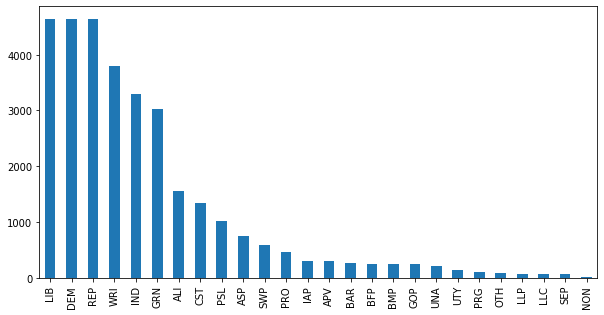

In [ ]:
plt.figure(figsize=(10,5))
data.party.value_counts().plot.bar()

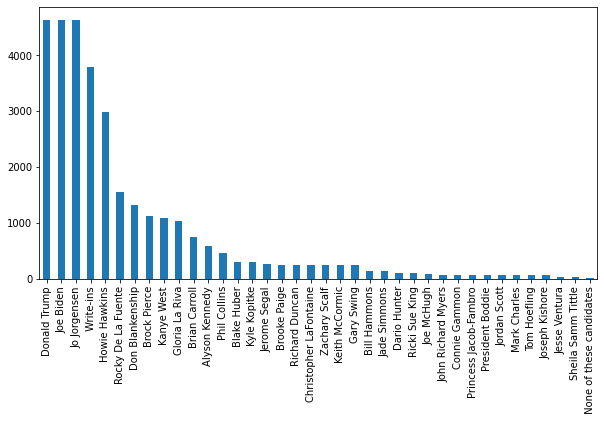

In [ ]:
plt.figure(figsize=(10,5))
data.candidate.value_counts().plot.bar()

Визуелизација на мапата на US, каде што се прикажува секоја држава и нејзината победничка партија. 

In [ ]:
state_codes = pd.read_csv("/content/drive/MyDrive/world_country_and_usa_states_latitude_and_longitude_values.csv")

dem_votes_per_state = data.merge(state_codes, left_on='state', right_on='usa_state')


fig = px.choropleth(dem_votes_per_state, 
                           locations='usa_state_code', 
                           color="party",
                           color_discrete_sequence= ["red", "blue"],
                           locationmode = 'USA-states',  
                           scope="usa",
                           title='USA Presidential Votes Counts' 
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

# **Normalizing data for classification**

Конвертирање на податоците во dummy променливи и лабелирање на колоната за победа во вредности од 0 и 1.

In [ ]:
X = data.drop(['won'], axis=1)
y = data.won.values

X = pd.get_dummies(X)
y = labelencoder.fit_transform(y)

Скалирање на податоците (со исфрлање на колоната за победа).

In [ ]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[ 1.10544315, -0.09164543, -0.1000659 , ..., -0.08316104,
        -0.06820689, -0.36550196],
       [ 1.0065187 , -0.09164543, -0.1000659 , ..., -0.08316104,
        -0.06820689, -0.36550196],
       [-0.10934797, -0.09164543, -0.1000659 , ..., -0.08316104,
        -0.06820689, -0.36550196],
       [-0.12677074, -0.09164543, -0.1000659 , ..., -0.08316104,
        -0.06820689, -0.36550196],
       [ 5.3070658 , -0.09164543, -0.1000659 , ..., -0.08316104,
        -0.06820689, -0.36550196]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# **Decision tree**

Партиционирање на податоците во подмножества кои содржат инстанци со слични вредности и користење на ентропија (која ни врати подобри резултати од gini index). Поставуваме вредност од 6 за max depth за максимална длабочина на дрвото, за да немаме overfitting на моделот.

In [ ]:
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6).fit(X_train, y_train)

yhat_tree = tree.predict(X_test)
yhat_tree[0:5]

array([0, 0, 0, 0, 0])

In [ ]:
print("Decision Tree evaluation\n")
ac=accuracy_score(y_test, yhat_tree)
ps = precision_score(y_test, yhat_tree)
rs = recall_score(y_test, yhat_tree)
print('accuracy of the model: ',ac)
print('precision score of the model: ',ps)
print('recall score of the model:',rs)

Decision Tree evaluation

accuracy of the model:  0.9456183965195774
precision score of the model:  0.8010526315789473
recall score of the model: 0.8253796095444685


5325 примероци се предвиделе како 0 и биле 0 (true negative).

189 примероци се предвиделе како 0 биле 1 (false positive). 

161 примероци се предвиделе како 1 и биле 0 (false negative).

761 примероци се предвиделе како 1 и биле 1 (true positive).

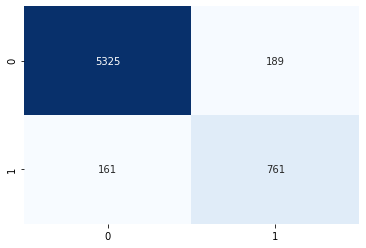

In [ ]:
cm = confusion_matrix(y_test, yhat_tree)
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)

# **Logistic regression**

Логистичка регресија дава бинарен одговор каде што имаме две зависни променливи со вредности 0 или 1 (win/lose). 

In [ ]:
lr = LogisticRegression(C = 0.01, solver = 'liblinear').fit(X_train, y_train)

yhat_lr = lr.predict(X_test)
yhat_lr[0:5]

array([0, 0, 0, 0, 0])

In [ ]:
print("Logistic Regression evaluation\n")

ac=accuracy_score(y_test, yhat_lr)
ps = precision_score(y_test, yhat_lr)
rs = recall_score(y_test, yhat_lr)
print('accuracy of the model: ',ac)
print('precision score of the model: ',ps)
print('recall score of the model: ',rs)

Logistic Regression evaluation

accuracy of the model:  0.8345245494095712
precision score of the model:  0.4334398296059638
recall score of the model:  0.4329787234042553


4964 примероци се предвиделе како 0 и биле 0 (true negative).

532 примероци се предвиделе како 0 биле 1 (false positive). 

533 примероци се предвиделе како 1 и биле 0 (false negative).

407 примероци се предвиделе како 1 и биле 1 (true positive).

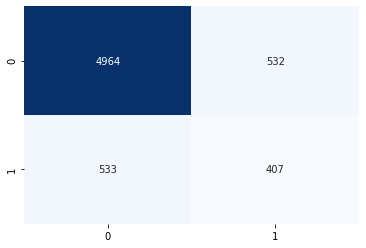

In [ ]:
cm = confusion_matrix(y_test, yhat_lr)
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)

# **XGBoost**

Го користиме Xgboost бидејќи враќа добри резултати кога има множеството на податоци каде што има мешавина од категориски и нумерички податоци (како што е во нашиот случај). 
Поставуваме вредност од 4 за max depth за да не биде многу комплексен моделот (да не дојде до  overfitting).
Поставуваме default вредност 1 за min_child_weight.
Поставуваме default вредност 10 за n_estimators.
Поставуваме вредност за n_jobs -1 за да немаме паралелни нишки.
Вредноста за learning_rate ја поставуваме 0.16 за намалување на cost function.

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=4, min_child_weight=1, n_estimators=10, n_jobs=-1, verbose=1, learning_rate=0.16)
model.fit(X_train, y_train)

y_pred_xgb = model.predict(X_test)

In [ ]:
print("XGBoost evaluation\n")

ac=accuracy_score(y_test, y_pred_xgb)
ps = precision_score(y_test, y_pred_xgb)
rs = recall_score(y_test, y_pred_xgb)
print('accuracy of the model: ',ac)
print('precision score of the model: ',ps)
print('recall score of the model: ',rs)

XGBoost evaluation

accuracy of the model:  0.9404909881914233
precision score of the model:  0.7892004153686397
recall score of the model:  0.8085106382978723


5322 примероци се предвиделе како 0 и биле 0 (true negative).

174 примероци се предвиделе како 0 биле 1 (false positive). 

154 примероци се предвиделе како 1 и биле 0 (false negative).

786 примероци се предвиделе како 1 и биле 1 (true positive).

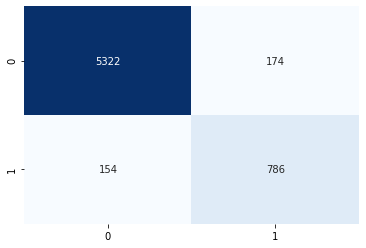

In [ ]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)

# **Keras**

Keras е библиотека во python која што враќа брзи и лесни резултатите за модели за длабоко учење. Ја користиме оваа библиотека бидејќи во поголем број случаеви враќа најдобри резулати.

Имаме на влез 3123 колони, и поставуваме слој со 128 неврони. 
Исто така, додаваме hidden слој со 32 неврона, и излезен слој со еден неврон.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(128, input_dim=3123, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(32,kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(1, kernel_initializer = 'uniform',activation='sigmoid'))

Ја користиме binary_crossentropy класата бидејќи нашата target колона ни се состои од податоци со вредност од 0 и 1.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=20)

Epoch 1/10
1288/1288 [==============================] - 5s 3ms/step - loss: 0.2959 - accuracy: 0.8723
Epoch 2/10
1288/1288 [==============================] - 4s 3ms/step - loss: 0.1222 - accuracy: 0.9389
Epoch 3/10
1288/1288 [==============================] - 4s 3ms/step - loss: 0.0637 - accuracy: 0.9778
Epoch 4/10
1288/1288 [==============================] - 4s 3ms/step - loss: 0.0479 - accuracy: 0.9851
Epoch 5/10
1288/1288 [==============================] - 4s 3ms/step - loss: 0.0318 - accuracy: 0.9902
Epoch 6/10
1288/1288 [==============================] - 4s 3ms/step - loss: 0.0204 - accuracy: 0.9918
Epoch 7/10
1288/1288 [==============================] - 4s 3ms/step - loss: 0.0138 - accuracy: 0.9946
Epoch 8/10
1288/1288 [==============================] - 4s 3ms/step - loss: 0.0085 - accuracy: 0.9964
Epoch 9/10
1288/1288 [==============================] - 4s 3ms/step - loss: 0.0051 - accuracy: 0.9977
Epoch 10/10
1288/1288 [==============================] - 4s 3ms/step - loss: 0.003

In [ ]:
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 99.89


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("Keras evaluation\n")

ac=accuracy_score(y_test, y_pred.round())
ps = precision_score(y_test, y_pred.round())
rs = recall_score(y_test, y_pred.round())
print('accuracy of the model: ',ac)
print('precision score of the model: ',ps)
print('recall score of the model: ',rs)

Keras evaluation

accuracy of the model:  0.9681479179614667
precision score of the model:  0.8875675675675676
recall score of the model:  0.8904555314533622


5410 примероци се предвиделе како 0 и биле 0 (true negative).

104 примероци се предвиделе како 0 биле 1 (false positive). 

101 примероци се предвиделе како 1 и биле 0 (false negative).

821 примероци се предвиделе како 1 и биле 1 (true positive).

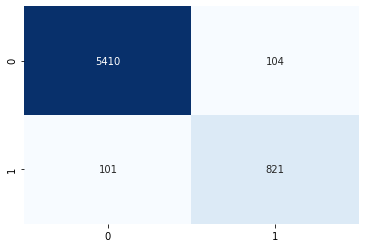

In [ ]:
cm = confusion_matrix(y_test, y_pred.round())
sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False)

# **Conclusion:**

Од сите модели што ги изградивме, како што очекувавме Keras ни врати модел со најдобри резултати. Со оваа документација постигнавме потврда за победата на Joe Biden. 